# Msprime Genetic Simulation Script

## Overview

This Python script simulates genetic data using the `msprime` library, which is designed for efficient population genetics simulations. The script incorporates a defined pedigree structure and demographic model to generate realistic genetic data that can be used for various analyses in genetic genealogy and population genetics research.

## Key Features

- **Pedigree-based Simulation**: Uses a user-provided pedigree file to model realistic family structures
- **Chromosome Simulation**: Can simulate all 22 autosomes or any subset specified by the user
- **Multi-population Demography**: Incorporates the American Admixture demographic model
- **Genetic Map Integration**: Uses realistic recombination rates based on HapMapII
- **Visual Pedigree Representation**: Generates a network diagram of the input pedigree

## How It Works

1. **Initialization**:
   - Parses command-line arguments
   - Sets up logging system
   - Loads environment variables (if available)

2. **Demographic Model Setup**:
   - Uses the AmericanAdmixture_4B11 model from stdpopsim
   - Populations included: African (AFR), European (EUR), Asian (ASIA), and admixed American (ADMIX)

3. **Rate Map Construction**:
   - Creates a genetic map incorporating multiple chromosomes
   - Sets high recombination rates between chromosomes to simulate chromosome breaks
   - Maps positions to their original chromosomes for later reference

4. **Pedigree Processing**:
   - Loads pedigree from a text file (.fam format)
   - Assigns generation numbers to each individual
   - Converts the text pedigree to msprime's internal format
   - Generates a visual diagram of the pedigree structure

5. **Simulation**:
   - First stage: Simulates inheritance through the fixed pedigree
   - Second stage: Extends the simulation back in time using:
     - Discrete-time Wright-Fisher model for recent generations
     - Standard coalescent for ancient ancestry
   - Adds mutations based on specified mutation rate
   - Saves tree sequence files for each replicate

## Usage

```bash
python msprime_simulation.py [OPTIONS]
```

### Options

- `--results-dir PATH`: Directory to store results
- `--num-replicates INT`: Number of simulation replicates (default: 10)
- `--mutation-rate FLOAT`: Mutation rate (default: 1.29e-8)
- `--log-level STRING`: Logging level (DEBUG, INFO, WARNING, ERROR)
- `--pedigree-file PATH`: Path to pedigree file (default: pedigree.fam)
- `--which-chromosomes LIST`: Comma-separated list of chromosomes (default: 1-22)
- `--genetic-map STRING`: Genetic map to use (default: HapMapII_GRCh38)

## Example Commands

Simulate all chromosomes with 10 replicates:
```bash
python msprime_simulation.py
```

Simulate only chromosomes 21 and 22 with 5 replicates:
```bash
python msprime_simulation.py --which-chromosomes 21,22 --num-replicates 5
```

Specify a custom output directory:
```bash
python msprime_simulation.py --results-dir ./my_results
```

## Output Files

- `*.trees`: Tree sequence files (one per replicate)
- `simulation_log.txt`: Log file with detailed progress information
- `diagram_msprime_pedigree.svg`: Visualization of the pedigree structure

## Requirements

- Python 3.7+
- msprime
- tskit
- stdpopsim
- numpy
- pandas
- matplotlib
- networkx

## Analyzing Results

The script generates tree sequence files (*.trees) that can be analyzed using separate tools or scripts. These files contain detailed information about:

- The genealogical relationships between individuals
- Mutation events along the genome
- Recombination breakpoints
- Individual metadata

You can analyze these files using the tskit library's powerful analytical capabilities or load them in other tools for further analysis.

## Pedigree File Format

The input pedigree file should be in PLINK .fam format with the following columns:
1. Family ID
2. Individual ID
3. Father ID (0 if unknown)
4. Mother ID (0 if unknown)
5. Sex (1=male, 2=female)
6. Phenotype (not used in simulation)

Example:
```
FAM 1 0 0 1 -9
FAM 2 0 0 2 -9
FAM 3 1 2 1 -9
FAM 4 0 0 2 -9
FAM 5 1 2 1 -9
```

In [ ]:
!poetry install --no-root

### Run the following command in your terminal window.

In [ ]:
%%bash

# RUN IN TERMINAL WINDOW

poetry run python scripts_support/msprime_simulation.py --which-chromosomes 21 --num-replicates 2

# Runtime: 0:0:17 - 0:0:34

# poetry run python scripts_support/msprime_simulation.py --which-chromosomes 1 --num-replicates 2

# Runtime: 0:15:37

In [ ]:
from pathlib import Path
from dotenv import load_dotenv
import os
import logging

In [ ]:
def find_comp_gen_dir():
    """Find the computational_genetic_genealogy directory by searching up from current directory."""
    current = Path.cwd()
    
    # Search up through parent directories
    while current != current.parent:
        # Check if target directory exists in current path
        target = current / 'computational_genetic_genealogy'
        if target.is_dir():
            return target
        # Move up one directory
        current = current.parent
    
    raise FileNotFoundError("Could not find computational_genetic_genealogy directory")

def load_env_file():
    """Find and load the .env file from the computational_genetic_genealogy directory."""
    try:
        # Find the computational_genetic_genealogy directory
        comp_gen_dir = find_comp_gen_dir()
        
        # Look for .env file
        env_path = comp_gen_dir / '.env'
        if not env_path.exists():
            print(f"Warning: No .env file found in {comp_gen_dir}")
            return None
        
        # Load the .env file
        load_dotenv(env_path, override=True)
        print(f"Loaded environment variables from: {env_path}")
        return env_path
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Use the function
env_path = load_env_file()

working_directory = os.getenv('PROJECT_WORKING_DIR', default=None)
data_directory = os.getenv('PROJECT_DATA_DIR', default=None)
references_directory = os.getenv('PROJECT_REFERENCES_DIR', default=None)
results_directory = os.getenv('PROJECT_RESULTS_DIR', default=None)
utils_directory = os.getenv('PROJECT_UTILS_DIR', default=None)

os.environ["WORKING_DIRECTORY"] = working_directory
os.environ["DATA_DIRECTORY"] = data_directory
os.environ["REFERENCES_DIRECTORY"] = references_directory
os.environ["RESULTS_DIRECTORY"] = results_directory
os.environ["UTILS_DIRECTORY"] = utils_directory

print(f"Working Directory: {working_directory}")
print(f"Data Directory: {data_directory}")
print(f"References Directory: {references_directory}")
print(f"Results Directory: {results_directory}")
print(f"Utils Directory: {utils_directory}")

os.chdir(working_directory)
print(f"The current directory is {os.getcwd()}")

# Introduction to Tree Sequences (ts)

Tree sequences are a powerful data structure developed for efficient storage and analysis of genetic ancestry information. They were developed as part of the [tskit](https://tskit.dev/) project to address computational challenges in population genetics.

## What is a Tree Sequence?

A tree sequence is a compact representation of:

1. **Ancestral Relationships**: The genealogical trees that relate individuals across different segments of the genome
2. **Genetic Variation**: The mutations that occurred along these ancestral lineages
3. **Genomic Locations**: The specific positions where recombination changes the ancestry pattern

## Key Benefits

- **Storage Efficiency**: Tree sequences can store complete evolutionary histories in a fraction of the space compared to traditional formats
- **Computational Speed**: Many population genetic analyses can be performed orders of magnitude faster
- **Lossless Compression**: Complete genealogical information is preserved, allowing exact reconstruction of genetic data

## Common Operations

```python
import tskit

# Load a tree sequence file
ts = tskit.load("simulation.trees")

# Basic information
print(f"Sequence length: {ts.sequence_length}")
print(f"Sample size: {ts.num_samples}")
print(f"Number of trees: {ts.num_trees}")
print(f"Number of mutations: {ts.num_mutations}")

# Iterate through trees along the genome
for tree in ts.trees():
    print(f"Tree covers positions {tree.interval}")
    
# Find shared ancestry
mrca = tree.mrca(sample1, sample2)  # Most recent common ancestor

# Calculate genetic statistics
diversity = ts.diversity()
```

## Usage in Simulations

Tree sequences are the primary output format from msprime simulations, preserving the full evolutionary history generated during the simulation. This makes them ideal for:

- Calculating population genetic statistics
- Identifying identity-by-descent segments
- Analyzing recombination patterns
- Studying the effects of selection

In [ ]:
# Basic information about the tree sequence

!tskit info ${RESULTS_DIRECTORY}/msprime_tree_replicate_0.trees

- Each tree represents the ancestry at a specific segment.
- A high number of trees indicates extensive recombination in your simulation.
- Number of samples: In a tree sequence from msprime, the samples represent haploid genomic samples, which means there are 2 per sampled diploid individual (one for each chromosome copy). Divide the number of samples by 2 to get the number of sampled diploid individuals.
- Number of individuals: This includes both the sampled individuals and their ancestors in the pedigree.
- Number of nodes: This represents all nodes in the tree sequence, including both sample nodes and ancestral nodes. Each node corresponds to a specific genomic segment in a specific individual.

In [ ]:
# For more detailed information

!tskit info ${RESULTS_DIRECTORY}/msprime_tree_replicate_0.trees

In [ ]:
import tskit

# Load the tree sequence
ts = tskit.load(f"{results_directory}/msprime_tree_replicate_0.trees")

# Print summary information
print(f"Sequence length: {ts.sequence_length}")
print(f"Number of trees: {ts.num_trees}")
print(f"Number of individuals: {ts.num_individuals}")
print(f"Number of mutations: {ts.num_mutations}")

# Tree Sequence Analysis Documentation

This document explains how to analyze tree sequence files generated by msprime simulations to extract identity-by-descent (IBD) segments and calculate pairwise genealogical relationships with multiple inheritance paths.

## Overview

The analysis script `analyze_tree_sequences.py` processes tree sequence files to:

1. **Extract IBD segments** that exceed a minimum length threshold (default: 3 cM)
2. **Calculate comprehensive pairwise MRCA** (Most Recent Common Ancestor) relationships accounting for multiple inheritance paths
3. **Determine TMRCA** (Time to Most Recent Common Ancestor) values for each distinct relationship
4. **Map genomic regions** where each MRCA exclusively applies

## Running the Analysis

### Command Line Usage

You can run the analysis script with various options:

```bash
python analyze_tree_sequences.py [OPTIONS]
```

### Options

- `--results-dir PATH`: Directory containing tree sequence files
- `--output-dir PATH`: Directory to save analysis results
- `--min-segment-length FLOAT`: Minimum IBD segment length in cM (default: 3.0)
- `--replicate INT`: Analyze a specific replicate (default: analyze all)
- `--max-time FLOAT`: Maximum time to look back for IBD segments (default: 50)
- `--log-level STRING`: Logging level (DEBUG, INFO, WARNING, ERROR)
- `--genetic-map STRING`: Genetic map name (default: HapMapII_GRCh38)
- `--chromosome-lengths FILE`: File with chromosome lengths (default: built-in values)

### Examples

Analyze all replicates with default settings:
```bash
python analyze_tree_sequences.py --results-dir results
```

Analyze only replicate 0 with a 5 cM threshold:
```bash
python analyze_tree_sequences.py --results-dir results --replicate 0 --min-segment-length 5.0
```

## Output Files

The script generates two CSV files for each analyzed tree sequence:

1. **IBD Segments File**: `ibd_segments_rep_X.csv`
   - Contains all IBD segments exceeding the minimum length threshold
   - Includes chromosome, position, length (in bp and cM), MRCA, and TMRCA

2. **Pairwise MRCA File**: `pairwise_mrca_rep_X.csv`
   - Contains all distinct MRCAs for each pair of samples
   - Includes genomic regions where each MRCA exclusively applies
   - Accounts for multiple inheritance paths between the same pair

## Understanding the Output

### IBD Segments File

The IBD segments file contains the following columns:

| Column | Description |
|--------|-------------|
| node1 | Node ID of the first sample |
| node2 | Node ID of the second sample |
| chromosome | Chromosome number where the segment is located |
| start_bp | Start position in base pairs (relative to chromosome) |
| end_bp | End position in base pairs (relative to chromosome) |
| length_bp | Length of the segment in base pairs |
| length_cm | Length of the segment in centiMorgans |
| mrca_node | Node ID of the most recent common ancestor |
| tmrca | Time to the most recent common ancestor |

### Comprehensive Pairwise MRCA File

The comprehensive pairwise MRCA file contains the following columns:

| Column | Description |
|--------|-------------|
| node1 | Node ID of the first sample |
| node2 | Node ID of the second sample |
| individual1 | Individual name/ID of the first sample |
| individual2 | Individual name/ID of the second sample |
| mrca_node | Node ID of this specific most recent common ancestor |
| tmrca | Time to this specific most recent common ancestor |
| total_length_bp | Total base pairs where this MRCA exclusively applies |
| covered_regions | Semicolon-separated list of genomic regions (start-end) where this MRCA applies |

## Technical Details

### Multiple Inheritance Paths

The comprehensive MRCA analysis accounts for the fact that two samples can be related through multiple common ancestors across different regions of the genome. For each pair, the script:

1. Identifies all MRCAs across their shared IBD segments
2. Tracks the genomic regions where each MRCA applies
3. Filters out redundant ancestry (regions where a more recent MRCA exists)
4. Returns only the distinct genealogical relationships

### Sample vs Individual

In tree sequences, "samples" typically refer to haploid genomic samples, with diploid individuals having two samples each (one for each chromosome copy). The analysis distinguishes between:

- **Nodes**: Individual haploid samples in the tree sequence
- **Individuals**: Diploid entities that contain two nodes (maternal and paternal haplotypes)

### BP to cM Conversion

The script converts base pair lengths to centiMorgans (cM) using chromosome-specific recombination rates from the specified genetic map. This ensures accurate genetic distance measurements for IBD segments.

### Chromosome Identification

For multi-chromosome simulations, the script identifies which chromosome each segment belongs to and calculates local positions within that chromosome. This allows for proper genetic distance calculations.

### Time Units

TMRCA values are in the time units used by the simulation (generations). These times represent how far back in the past the most recent common ancestor lived.

## Troubleshooting

### Type Errors with Node IDs

If you encounter type errors related to node IDs (e.g., "numpy.float64 object cannot be interpreted as an integer"), ensure that node IDs are properly converted to integers when used with tree methods:

```python
# In calculate_comprehensive_pairwise_mrca function
ibd_segments_df['node1'] = ibd_segments_df['node1'].astype(int)
ibd_segments_df['node2'] = ibd_segments_df['node2'].astype(int)
```

### Memory Issues

For very large tree sequences, the analysis may consume significant memory. Consider strategies to reduce memory usage:

1. Analyze one replicate at a time
2. Save intermediate results to disk and process in stages
3. Filter IBD segments more aggressively using a higher length threshold

### Empty IBD Results

If no IBD segments are found, check:
1. The minimum segment length threshold (try lowering it)
2. The maximum time parameter (try increasing it)
3. The genetic map being used (ensure it's appropriate for your simulation)

### Explore IBD segments and MRCA data

In [ ]:
%%bash

# RUN IN THE TERMINAL WINDOW

# To analyze just replicate 0
poetry run python scripts_support/analyze_tree_sequences.py --replicate 0

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tskit

# Set plotting styles
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

replicate = 0  # Change this to analyze a different replicate

In [ ]:
# --- 1. Load the tree sequence ---
ts_file = os.path.join(results_directory, f"msprime_tree_replicate_{replicate}.trees")
ts = tskit.load(ts_file)

print(f"Loaded tree sequence from {ts_file}")
print(f"Sequence length: {ts.sequence_length:,.0f} bp")
print(f"Number of trees: {ts.num_trees:,}")
print(f"Number of samples: {ts.num_samples:,}")
print(f"Number of individuals: {ts.num_individuals:,}")
print(f"Number of nodes: {ts.num_nodes:,}")
print(f"Number of mutations: {ts.num_mutations:,}")

- Each tree represents the ancestry at a specific segment.
- A high number of trees indicates extensive recombination in your simulation.
- Number of samples: In a tree sequence from msprime, the samples represent haploid genomic samples, which means there are 2 per sampled diploid individual (one for each chromosome copy). Divide the number of samples by 2 to get the number of sampled diploid individuals.
- Number of individuals: This includes both the sampled individuals and their ancestors in the pedigree.
- Number of nodes: This represents all nodes in the tree sequence, including both sample nodes and ancestral nodes. Each node corresponds to a specific genomic segment in a specific individual.

In [ ]:
# --- 2. Load the analysis results ---
ibd_file = os.path.join(results_directory, f"ibd_segments_rep_{replicate}.csv")
mrca_file = os.path.join(results_directory, f"pairwise_mrca_rep_{replicate}.csv")

# Check if files exist (run the analysis script first if they don't)
if not os.path.exists(ibd_file) or not os.path.exists(mrca_file):
    print("Analysis files not found. Run the analyze_tree_sequences.py script first.")
else:
    ibd_df = pd.read_csv(ibd_file)
    mrca_df = pd.read_csv(mrca_file)
    
    print(f"\nLoaded IBD segments data: {len(ibd_df)} segments")
    print(f"Loaded pairwise MRCA data: {len(mrca_df)} pairs")
    
    display(ibd_df.head())
    
    # Summary statistics of IBD segment lengths
    print("\nSummary of IBD segment lengths (cM):")
    print(ibd_df['length_cm'].describe())

- An IBD segment might span multiple adjacent trees that share the same MRCA between the two nodes.
- The IBD segment itself is defined by genomic coordinates (start and end positions) where two individuals share identical genetic material inherited from a common ancestor.
- The code is using the leftmost position of the segment to find one representative tree, which works because the MRCA should be consistent across the entire IBD segment. If the MRCA changed, that would define a different segment.

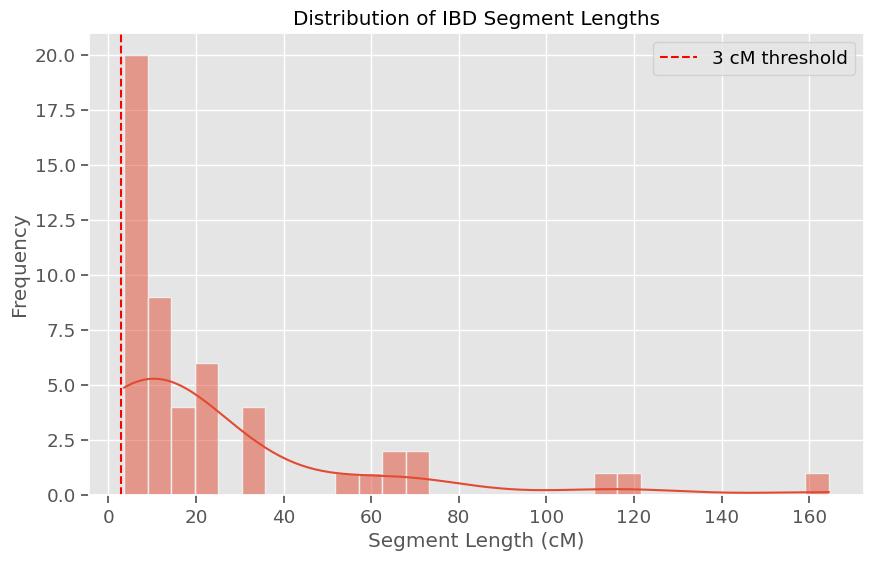

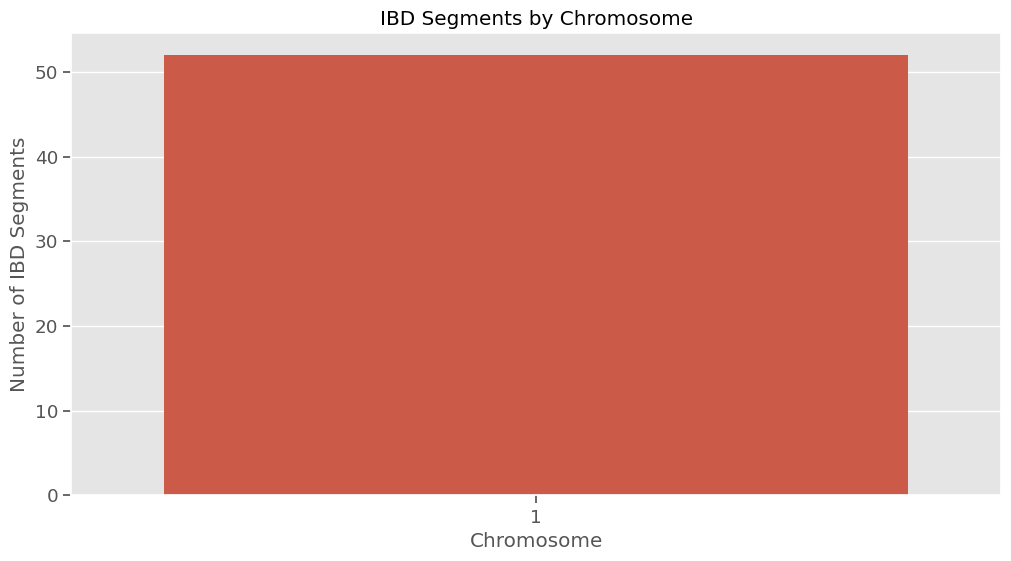


IBD segment length (cM) by chromosome:


,count,mean,median,min,max
chromosome_str,,,,,
1,52,24.99,9.54,3.6,164.44


In [70]:
# --- 3. Explore IBD segments ---

if 'ibd_df' in locals() and not ibd_df.empty:
    
    # Plot distribution of IBD segment lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(ibd_df['length_cm'], bins=30, kde=True)
    plt.xlabel('Segment Length (cM)')
    plt.ylabel('Frequency')
    plt.title('Distribution of IBD Segment Lengths')
    plt.axvline(x=3, color='red', linestyle='--', label='3 cM threshold')
    plt.legend()
    plt.show()
    
    # Plot IBD segments by chromosome
    if 'chromosome' in ibd_df.columns:
        plt.figure(figsize=(12, 6))
        # Convert chromosome to string to handle different data types cleanly
        ibd_df['chromosome_str'] = ibd_df['chromosome'].astype(str)
        chrom_counts = ibd_df['chromosome_str'].value_counts().sort_index()
        
        # Create the bar plot
        sns.barplot(x=chrom_counts.index, y=chrom_counts.values)
        plt.xlabel('Chromosome')
        plt.ylabel('Number of IBD Segments')
        plt.title('IBD Segments by Chromosome')
        plt.xticks(rotation=0)
        plt.show()
        
        # Show summary statistics by chromosome
        print("\nIBD segment length (cM) by chromosome:")
        chrom_stats = ibd_df.groupby('chromosome_str')['length_cm'].agg(['count', 'mean', 'median', 'min', 'max']).round(2)
        display(chrom_stats)

The red line in the histogram represents a kernel density estimate (KDE) of the distribution of IBD segment lengths. It's essentially a smoothed version of the histogram that helps visualize the underlying probability density function of your data. Unlike the histogram bars which show the actual count or frequency in each bin, the KDE curve provides a continuous estimation of the distribution shape.


Summary of TMRCA values (generations):
count    37.000000
mean     12.796088
std      16.165237
min       1.000000
25%       2.000000
50%       5.000000
75%      17.000000
max      45.529499
Name: tmrca, dtype: float64


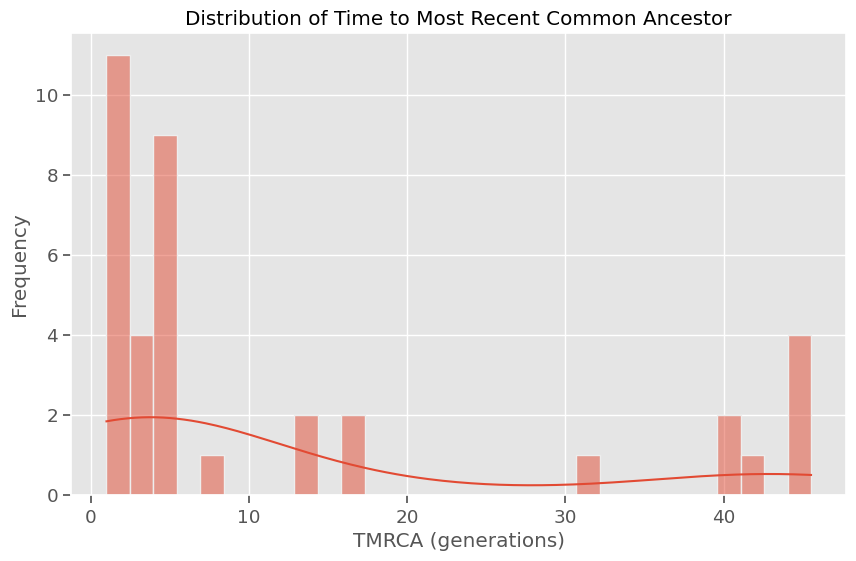

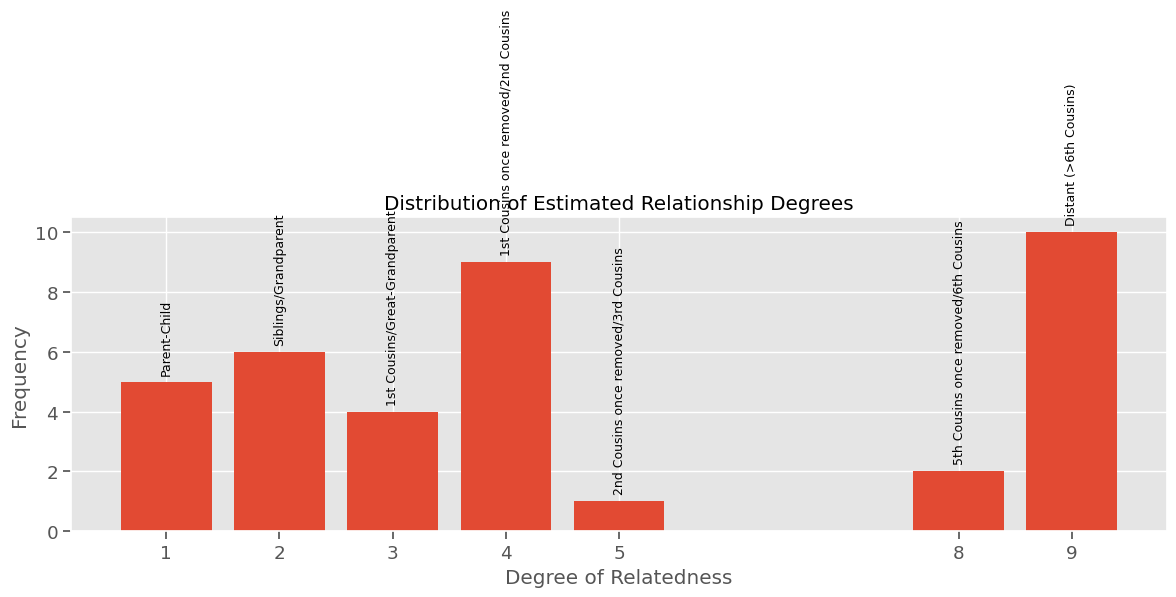

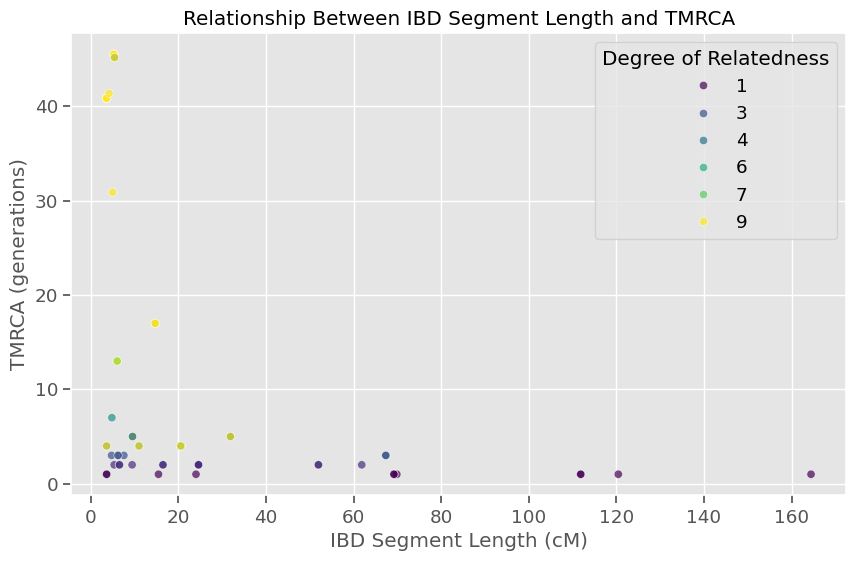

In [71]:
# --- 4. Explore Pairwise MRCA data ---

def estimate_degree_of_relatedness(tmrca):
    """
    Estimate the degree of relatedness based on TMRCA value.
    
    Args:
        tmrca: Time to Most Recent Common Ancestor in generations
        
    Returns:
        (degree, relationship_description)
    """
    if tmrca <= 1:
        return (1, "Parent-Child")
    elif tmrca <= 2:
        return (2, "Siblings/Grandparent")
    elif tmrca <= 3:
        return (3, "1st Cousins/Great-Grandparent")
    elif tmrca <= 5:
        return (4, "1st Cousins once removed/2nd Cousins")
    elif tmrca <= 7:
        return (5, "2nd Cousins once removed/3rd Cousins")
    elif tmrca <= 9:
        return (6, "3rd Cousins once removed/4th Cousins")
    elif tmrca <= 11:
        return (7, "4th Cousins once removed/5th Cousins")
    elif tmrca <= 13:
        return (8, "5th Cousins once removed/6th Cousins")
    else:
        return (9, "Distant (>6th Cousins)")

if 'mrca_df' in locals() and not mrca_df.empty:
    # Add estimated degree of relatedness
    mrca_df['degree'], mrca_df['relationship'] = zip(*mrca_df['tmrca'].apply(estimate_degree_of_relatedness))
    
    # Summary statistics of TMRCA
    print("\nSummary of TMRCA values (generations):")
    print(mrca_df['tmrca'].describe())
    
    # Plot distribution of TMRCA values
    plt.figure(figsize=(10, 6))
    sns.histplot(mrca_df['tmrca'], bins=30, kde=True)
    plt.xlabel('TMRCA (generations)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Time to Most Recent Common Ancestor')
    plt.show()
    
    # Plot distribution of relationship degrees
    plt.figure(figsize=(12, 6))
    degree_counts = mrca_df['degree'].value_counts().sort_index()
    bars = plt.bar(degree_counts.index, degree_counts.values)
    
    # Add relationship labels
    for i, (degree, count) in enumerate(degree_counts.items()):
        rel = mrca_df[mrca_df['degree'] == degree]['relationship'].iloc[0]
        plt.annotate(rel, xy=(degree, count), xytext=(0, 5), 
                     textcoords="offset points", ha='center', va='bottom',
                     rotation=90, fontsize=9)
    
    plt.xlabel('Degree of Relatedness')
    plt.ylabel('Frequency')
    plt.title('Distribution of Estimated Relationship Degrees')
    plt.xticks(degree_counts.index)
    plt.tight_layout()
    plt.show()
    
    # Relationship between segment length and TMRCA
    plt.figure(figsize=(10, 6))
    if 'ibd_df' in locals() and not ibd_df.empty:
        # Create a merged dataset of IBD segments with their TMRCA
        combined_data = pd.merge(
            ibd_df[['node1', 'node2', 'length_cm', 'tmrca']],
            mrca_df[['node1', 'node2', 'tmrca', 'degree', 'relationship']],
            on=['node1', 'node2'],
            how='left',
            suffixes=('_segment', '_mrca')
        )
        
        # Plot the relationship
        sns.scatterplot(data=combined_data, x='length_cm', y='tmrca_segment', 
                       hue='degree', palette='viridis', alpha=0.7)
        plt.xlabel('IBD Segment Length (cM)')
        plt.ylabel('TMRCA (generations)')
        plt.title('Relationship Between IBD Segment Length and TMRCA')
        plt.legend(title='Degree of Relatedness')
        plt.show()

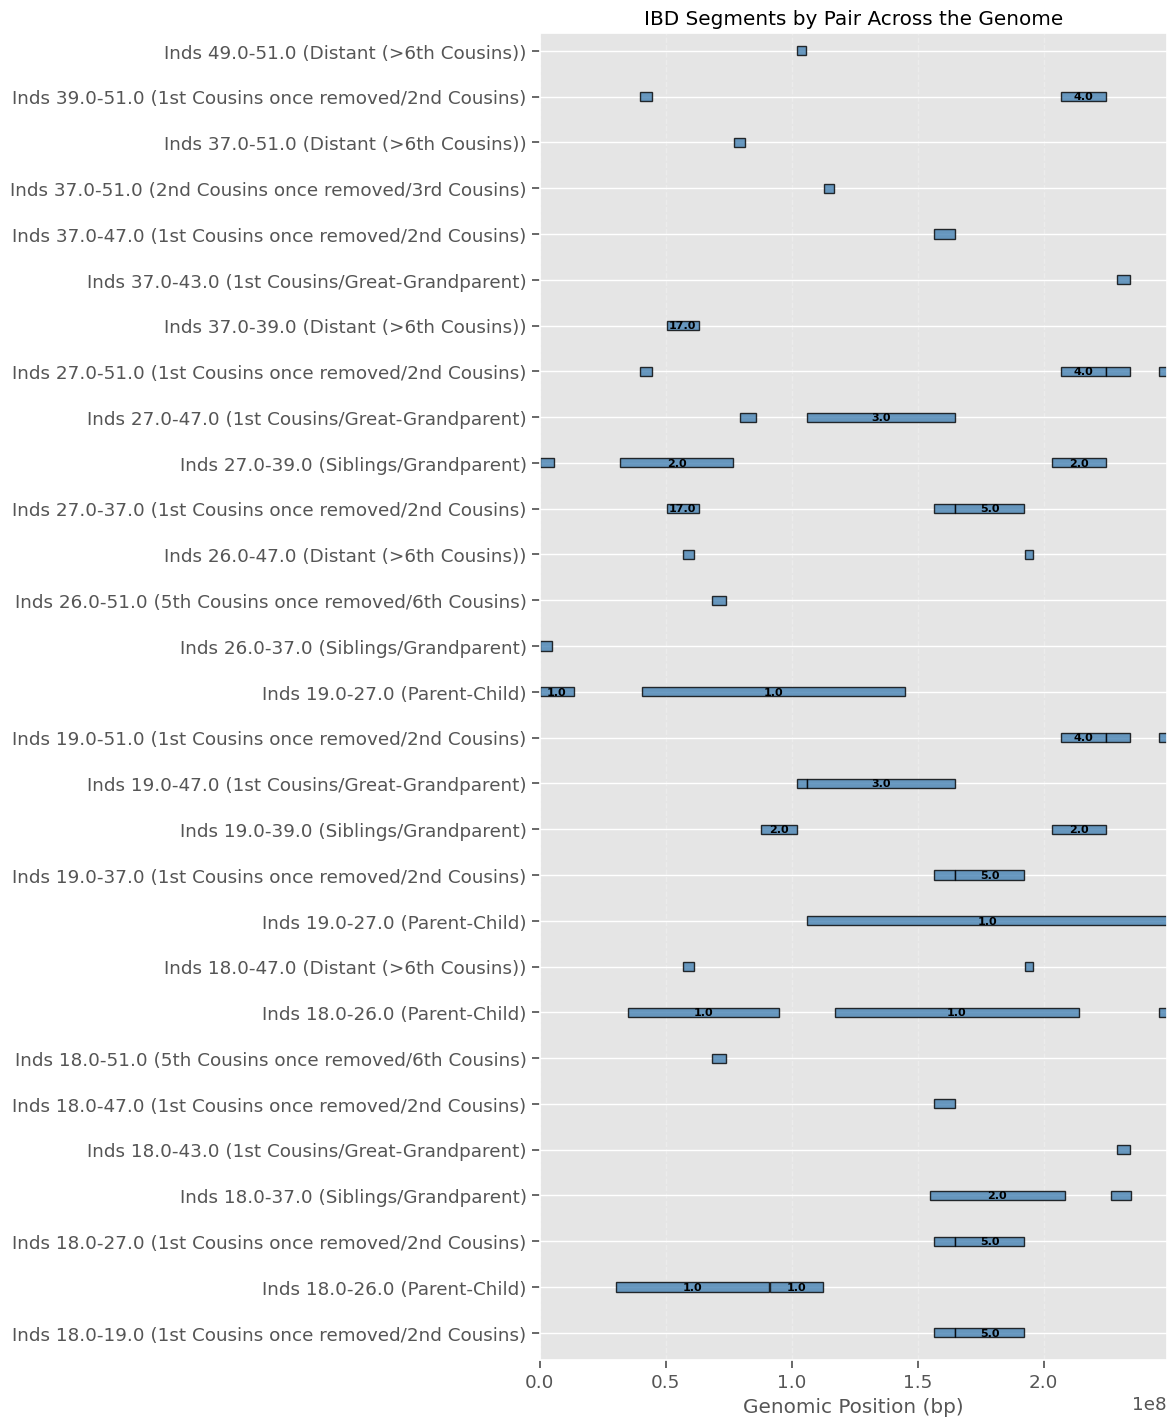

In [68]:
def visualize_mrca_regions(ts, pairwise_mrca_df, max_pairs=None):
    """
    Visualize the genomic regions covered by different MRCAs for all pairs.
    Uses thin horizontal bars for better visualization of overlapping segments.
    
    Args:
        ts: Tree sequence object
        pairwise_mrca_df: DataFrame from calculate_comprehensive_pairwise_mrca
        max_pairs: Maximum number of pairs to show (None for all)
        
    Returns:
        matplotlib figure
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np
    import logging

    # Get unique pairs
    pairs = set(zip(pairwise_mrca_df['node1'], pairwise_mrca_df['node2']))
    if not pairs:
        logging.warning("No pairs found in the DataFrame")
        return None

    # Sort pairs and limit if needed
    pairs_list = sorted(list(pairs))
    if max_pairs and len(pairs_list) > max_pairs:
        pairs_list = pairs_list[:max_pairs]
        print(f"Showing first {max_pairs} of {len(pairs)} pairs")

    # Create a single figure
    fig, ax = plt.subplots(figsize=(12, max(4, len(pairs_list) * 0.5)))

    # Track pair y-positions
    pair_positions = {}
    current_y = 0

    # Add estimated degree of relatedness if not already present
    if 'degree' not in pairwise_mrca_df.columns:
        pairwise_mrca_df['degree'], pairwise_mrca_df['relationship'] = zip(*pairwise_mrca_df['tmrca'].apply(estimate_degree_of_relatedness))

    # Process each pair
    for i, pair in enumerate(pairs_list):
        node1, node2 = pair

        # Filter the DataFrame for this pair
        pair_data = pairwise_mrca_df[
            (pairwise_mrca_df['node1'] == node1) & 
            (pairwise_mrca_df['node2'] == node2)
        ]

        if len(pair_data) == 0:
            continue

        # Get individual IDs if available
        has_ind_ids = 'individual1_id' in pair_data.columns and 'individual2_id' in pair_data.columns
        if has_ind_ids:
            ind1_id = pair_data['individual1_id'].iloc[0]
            ind2_id = pair_data['individual2_id'].iloc[0]
            pair_label = f"Inds {ind1_id}-{ind2_id}"
        else:
            pair_label = f"Nodes {node1}-{node2}"

        # Store this pair's y position
        pair_positions[pair] = current_y

        # Plot each MRCA's regions
        for _, row in pair_data.iterrows():
            mrca = row['mrca_node']
            tmrca = row['tmrca']

            regions = row['covered_regions'].split(';')
            for region in regions:
                start, end = map(int, region.split('-'))
                height = 0.2  # Very thin bar

                # Create horizontal rectangle - use a consistent color
                rect = patches.Rectangle(
                    (start, current_y), width=end - start, height=height, 
                    linewidth=1, edgecolor='black', facecolor='steelblue', 
                    alpha=0.8
                )
                ax.add_patch(rect)

                # For wide enough segments, add TMRCA text in the middle
                if end - start > ts.sequence_length / 20:
                    mid_point = start + (end - start) / 2
                    ax.text(mid_point, current_y + height / 2, f"{tmrca:.1f}",
                            ha='center', va='center', fontsize=8, color='black',
                            fontweight='bold')

        # Increment y position for next pair
        current_y += 1

    # Set plot parameters
    ax.set_ylim(-0.5, current_y - 0.5)
    ax.set_xlim(0, ts.sequence_length)
    ax.set_xlabel("Genomic Position (bp)")

    # Create y-tick labels with pair information
    yticks = []
    yticklabels = []
    for pair, y_pos in pair_positions.items():
        yticks.append(y_pos + 0.1)  # Center of the thin bar
        node1, node2 = pair

        # Get pair data again
        pair_data = pairwise_mrca_df[
            (pairwise_mrca_df['node1'] == node1) & 
            (pairwise_mrca_df['node2'] == node2)
        ]

        # Get label information
        has_ind_ids = 'individual1_id' in pair_data.columns and 'individual2_id' in pair_data.columns
        if has_ind_ids:
            ind1_id = pair_data['individual1_id'].iloc[0]
            ind2_id = pair_data['individual2_id'].iloc[0]
            pair_label = f"Inds {ind1_id}-{ind2_id}"
        else:
            pair_label = f"{node1}-{node2}"

        # Add average TMRCA and relationship if available
        avg_tmrca = pair_data['tmrca'].mean()
        avg_degree = pair_data['degree'].mean() if 'degree' in pair_data.columns else estimate_degree_of_relatedness(avg_tmrca)[0]
        relationship = pair_data['relationship'].iloc[0] if 'relationship' in pair_data.columns else estimate_degree_of_relatedness(avg_tmrca)[1]

        yticklabels.append(f"{pair_label} ({relationship})")

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    # Add grid lines for easier position reference
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    ax.set_title("IBD Segments by Pair Across the Genome")
    plt.tight_layout()

    return fig

# Revised usage:
fig = visualize_mrca_regions(ts, mrca_df)
plt.show()

- The numbers displayed inside the bars in the visualization represent the TMRCA (Time to Most Recent Common Ancestor) values, measured in generations.


Total IBD sharing between individual pairs:


,individual1_id,individual2_id,total_sharing_cm,segment_count,relationship
7,19,27,300.359607,3,Parent-Child
1,18,26,278.631445,5,Parent-Child
16,27,39,83.136870,3,Siblings/Grandparent
17,27,47,74.932324,2,1st Cousins/Great-Grandparent
10,19,47,72.124974,2,1st Cousins/Great-Grandparent
3,18,37,71.325548,2,Siblings/Grandparent
15,27,37,56.134068,3,1st Cousins once removed/2nd Cousins
0,18,19,41.432071,2,1st Cousins once removed/2nd Cousins
2,18,27,41.432071,2,1st Cousins once removed/2nd Cousins
8,19,37,41.432071,2,1st Cousins once removed/2nd Cousins


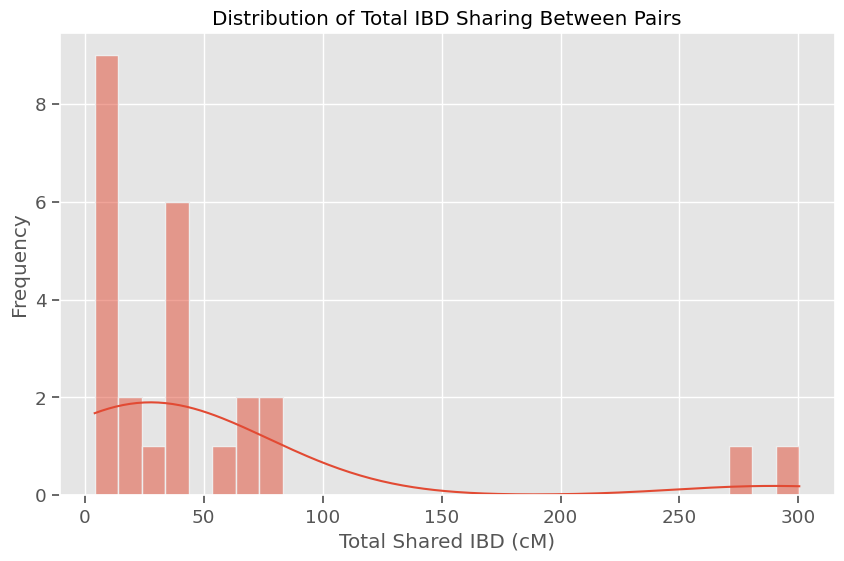

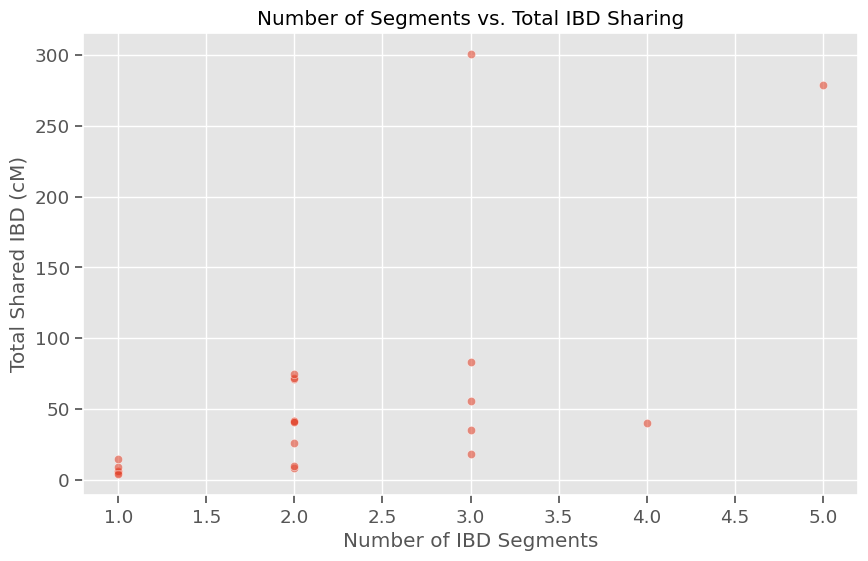

In [65]:
# --- 7. Advanced analysis: Total sharing between pairs ---

# If IBD data is available, calculate total sharing between pairs
if 'ibd_df' in locals() and not ibd_df.empty:
    # Check if individual IDs are in the dataframe
    if 'individual1_id' in ibd_df.columns and 'individual2_id' in ibd_df.columns:
        # Group by individual pairs and sum segment lengths
        pair_sharing = ibd_df.groupby(['individual1_id', 'individual2_id'])['length_cm'].sum().reset_index()
        pair_sharing.columns = ['individual1_id', 'individual2_id', 'total_sharing_cm']
        
        # Add count of segments
        segment_counts = ibd_df.groupby(['individual1_id', 'individual2_id']).size().reset_index(name='segment_count')
        pair_sharing = pair_sharing.merge(segment_counts, on=['individual1_id', 'individual2_id'])
        
        # Add any additional metadata if available (like relationship information)
        if 'mrca_df' in locals() and not mrca_df.empty and 'relationship' in mrca_df.columns:
            # Get most common relationship type for each pair
            relationships = mrca_df.groupby(['individual1_id', 'individual2_id'])['relationship'].agg(
                lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "Unknown"
            ).reset_index()
            pair_sharing = pair_sharing.merge(relationships, on=['individual1_id', 'individual2_id'], how='left')
        
        print("\nTotal IBD sharing between individual pairs:")
        display(pair_sharing.sort_values('total_sharing_cm', ascending=False).head(10))
    else:
        # Fallback to node-based analysis if individual IDs are not available
        pair_sharing = ibd_df.groupby(['node1', 'node2'])['length_cm'].sum().reset_index()
        pair_sharing.columns = ['node1', 'node2', 'total_sharing_cm']
        
        # Add count of segments
        segment_counts = ibd_df.groupby(['node1', 'node2']).size().reset_index(name='segment_count')
        pair_sharing = pair_sharing.merge(segment_counts, on=['node1', 'node2'])
        
        print("\nTotal IBD sharing between node pairs:")
        display(pair_sharing.sort_values('total_sharing_cm', ascending=False).head(10))
    
    # Plot distribution of total sharing
    plt.figure(figsize=(10, 6))
    sns.histplot(pair_sharing['total_sharing_cm'], bins=30, kde=True)
    plt.xlabel('Total Shared IBD (cM)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Total IBD Sharing Between Pairs')
    plt.show()
    
    # Plot segment count vs total sharing
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='segment_count', y='total_sharing_cm', data=pair_sharing, alpha=0.6)
    plt.xlabel('Number of IBD Segments')
    plt.ylabel('Total Shared IBD (cM)')
    plt.title('Number of Segments vs. Total IBD Sharing')
    plt.show()

In [1]:
# Explicit grouping by individual IDs
group_cols = ['individual1_id', 'individual2_id']

# Aggregate the IBD data for each pair:
# - total_length_bp: sum of shared base pairs.
# - total_length_cm: sum of shared centiMorgans.
# - num_segments: count of segments shared.
agg_df = ibd_df.groupby(group_cols).agg(
    total_length_bp=('length_bp', 'sum'),
    total_length_cm=('length_cm', 'sum'),
    num_segments=('length_bp', 'count')
).reset_index()

print("Aggregated IBD sharing data by pair:")
print(agg_df.head())

# --- KDE Plot for Total Shared Length (bp) vs. Number of Segments ---

# Create a bivariate KDE plot using seaborn jointplot (for bp)
kde_bp = sns.jointplot(
    data=agg_df,
    x='num_segments',
    y='total_length_bp',
    kind='kde',
    fill=True,   # Fill the contours
    height=8
)
kde_bp.set_axis_labels("Number of Segments Shared", "Total Shared Length (bp)")
plt.suptitle("Bivariate KDE: Number of Segments vs. Total Shared Length (bp)", y=1.02)
plt.show()

NameError: name 'ibd_df' is not defined

In [ ]:
# --- KDE Plot for Total Shared Length (cM) vs. Number of Segments ---

# Create a bivariate KDE plot using seaborn jointplot (for cM)
kde_cm = sns.jointplot(
    data=agg_df,
    x='num_segments',
    y='total_length_cm',
    kind='kde',
    fill=True,
    height=8
)
kde_cm.set_axis_labels("Number of Segments Shared", "Total Shared Length (cM)")
plt.suptitle("Bivariate KDE: Number of Segments vs. Total Shared Length (cM)", y=1.02)
plt.show()

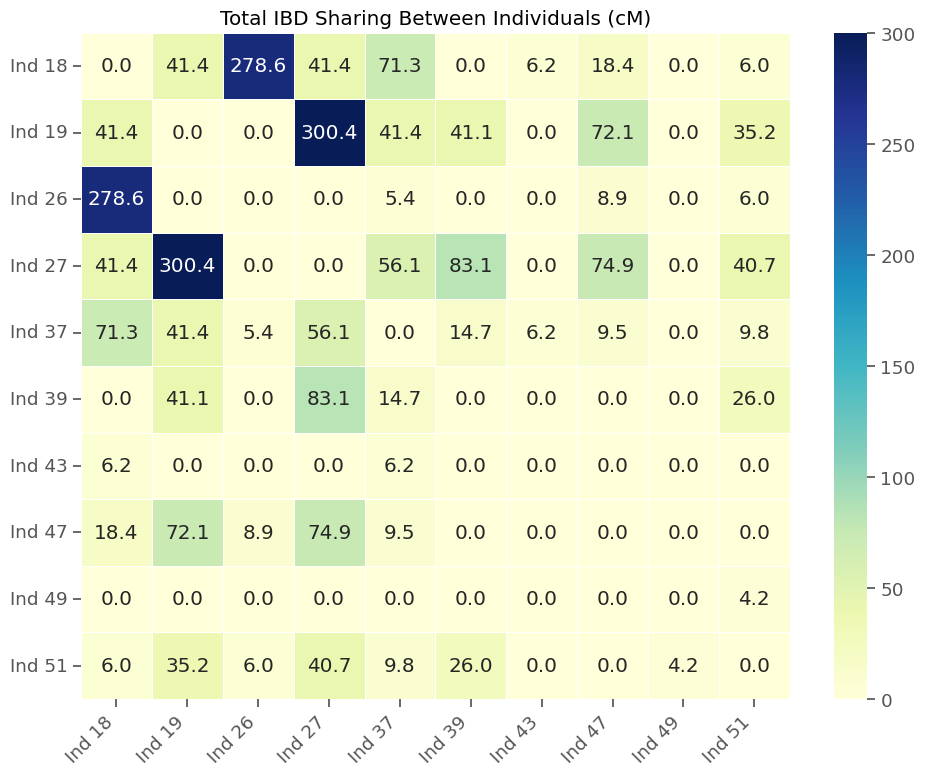

In [66]:
# --- 8. Create IBD sharing heatmap ---

def create_ibd_sharing_heatmap(ibd_df, max_individuals=None):
    """
    Create a heatmap showing total IBD sharing between all individuals.
    
    Args:
        ibd_df: DataFrame with IBD segments
        max_individuals: Maximum number of individuals to include (None for all)
        
    Returns:
        matplotlib figure
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Check if individual IDs are in the dataframe
    if 'individual1_id' in ibd_df.columns and 'individual2_id' in ibd_df.columns:
        # Group by individual pairs and sum segment lengths
        pair_sharing = ibd_df.groupby(['individual1_id', 'individual2_id'])['length_cm'].sum().reset_index()
        id1_col, id2_col = 'individual1_id', 'individual2_id'
    else:
        # Fallback to node-based analysis
        pair_sharing = ibd_df.groupby(['node1', 'node2'])['length_cm'].sum().reset_index()
        id1_col, id2_col = 'node1', 'node2'
    
    # Get all unique individuals
    all_individuals = sorted(list(set(pair_sharing[id1_col].unique()) | set(pair_sharing[id2_col].unique())))
    
    # Limit the number of individuals if specified
    if max_individuals and len(all_individuals) > max_individuals:
        all_individuals = all_individuals[:max_individuals]
        print(f"Limiting heatmap to first {max_individuals} individuals")
    
    # Create a matrix for the heatmap
    n = len(all_individuals)
    sharing_matrix = np.zeros((n, n))
    
    # Create lookup for individual index
    ind_to_idx = {ind: i for i, ind in enumerate(all_individuals)}
    
    # Fill the matrix with sharing values
    for _, row in pair_sharing.iterrows():
        ind1, ind2 = row[id1_col], row[id2_col]
        if ind1 in ind_to_idx and ind2 in ind_to_idx:
            i, j = ind_to_idx[ind1], ind_to_idx[ind2]
            sharing_matrix[i, j] = row['length_cm']
            sharing_matrix[j, i] = row['length_cm']  # Mirror since sharing is symmetric
    
    # Create labels
    labels = [f"Ind {i}" for i in all_individuals]
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(sharing_matrix, annot=True, fmt=".1f", cmap="YlGnBu", 
                    xticklabels=labels, yticklabels=labels, linewidths=0.5)
    
    # Adjust labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.title("Total IBD Sharing Between Individuals (cM)")
    plt.tight_layout()
    
    return plt.gcf()

# If IBD data is available, create a heatmap
if 'ibd_df' in locals() and not ibd_df.empty:
    # Create and show the heatmap
    fig = create_ibd_sharing_heatmap(ibd_df)
    plt.show()

# Appendix

### Here are some examples of how to run the script using various arguments

In [ ]:
%%bash

# RUN IN TERMINAL WINDOW

# For simulating the autosomes
poetry run python scripts_support/msprime_simulation.py --num-replicates 2

# For simulating just a few chromosomes to test:
poetry run python scripts_support/msprime_simulation.py --which-chromosomes 21 --num-replicates 2

# To specify a different location for the results directory other than what in your .env file:
poetry run python scripts_support/msprime_simulation.py --results-dir ./my_results --num-replicates 5 --which-chromosomes 21,22

# Understanding the stdpopsim Warning Messages

When running the msprime simulation script, you might encounter warning messages similar to:

```
FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
```

## What These Warnings Mean

These are `FutureWarning` messages from the pandas library, which is used by the stdpopsim package. They indicate that the code is using a deprecated method that will be removed in future versions of pandas.

Specifically, the warnings are about:

1. Converting a pandas Series with a single value to an integer using `int(series)` 
2. The recommended approach is to use `int(series.iloc[0])` instead

## Why You're Seeing These Warnings

The warnings are coming from the demographic models in the stdpopsim package (version 0.2.0), specifically in the HomSap/demographic_models.py file. This is not an issue with your simulation script but with the library it depends on.

These warnings appear when:
- The script loads the demographic model using `species.get_demographic_model("AmericanAdmixture_4B11")`
- The demographic model code uses pandas to process timing information

## Impact on Your Simulations

The good news is that these warnings:
- Don't affect the correctness of your simulation results
- Don't cause the script to crash or fail
- Are purely informational about future compatibility issues

## Potential Solutions

If you find the warnings distracting, you have several options:

1. **Suppress the warnings in your script**:
   ```python
   import warnings
   warnings.filterwarnings("ignore", category=FutureWarning)
   ```

2. **Update the stdpopsim package** (if a newer version is available):
   ```bash
   pip install --upgrade stdpopsim
   ```
   or
   ```bash
   poetry update stdpopsim
   ```

3. **Create a local patch** for the stdpopsim library if you have the technical skills and need to fix it immediately.

4. **Report the issue** to the stdpopsim developers on their GitHub repository.

## Recommendation

For most users, simply ignoring these warnings is reasonable as they don't affect simulation results. If you're developing code that others will use, consider adding a warning filter to prevent confusion.